# 1. Подключение пакетов и инициализация необходимых функций 

In [1]:
# data
# system
import os
import time
import math
import ast
import random
# wfdm
import wfdb
# tqdm
from tqdm import tqdm
# numpy and pandas
import pandas as pd
import numpy as np
# sklearn
from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline
# tslearn
# from tslearn.utils import to_time_series, to_time_series_dataset, save_time_series_txt, load_time_series_txt
# from tslearn.preprocessing import TimeSeriesScalerMinMax, TimeSeriesResampler, TimeSeriesScalerMeanVariance
# sktime
from sktime.transformations.panel.compose import ColumnConcatenator
# tsaug
from tsaug import AddNoise

# visualization
# matplotlib
import matplotlib.pyplot as plt
# seaborn
import seaborn as sns
# sktime
from sktime.utils.plotting import plot_series

# metrics
# sklearn
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, pairwise_distances, classification_report
# sktime
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError, MeanSquaredError, mean_absolute_percentage_error

# model
# sklearn
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
# from sklearn.calibration import CalibratedClassifierCV
# sktime
from sktime.classification.interval_based import TimeSeriesForestClassifier, DrCIF
from sktime.classification.kernel_based import RocketClassifier
# tslearn
# from tslearn.neighbors import KNeighborsTimeSeriesClassifier
# from tslearn.svm import TimeSeriesSVC
# tensorflow
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras import optimizers
from keras import layers

np.random.seed(42)



In [2]:
# Transformations

def fourier_transform(X, coeffs=80):
    X_ft = np.empty_like(X)
    for i in range(len(X)):
        sample_fft = np.fft.rfft(X[i].T)
        indices = np.array([[j < coeffs for j, _ in enumerate(sample_fft[k])] for k in range(len(sample_fft))])
        X_ft[i] = np.fft.irfft(indices * sample_fft).T
    
    return X_ft

def rolling_average(X, n=4): # n - размер окна
    shape = list(X.shape)
    shape[1] -= n-1 
    X_ra = np.empty(shape)
    for i in range(len(X)):
        sample = X[i].T
        X_ra[i] = np.array([np.convolve(signal, np.ones(n), 'valid') / n for signal in sample]).T
    
    return X_ra

# Metrics and confusion matrix

def draw_confusion_matrix(y, y_pred):
    print(classification_report(y, y_pred))
    sns.heatmap(confusion_matrix(y, y_pred), square=True, annot=True, fmt='.0f', cmap=plt.cm.Blues)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")

def elimination_imbalance(X, y):
  n_classes = y.shape[1]
  unique = np.unique(y, axis = 0)
  for i in range(n_classes):
    index_want = (np.where((y == unique[i]).all(axis=1))[0])
    num_want = math.floor(index_want.shape[0]/100)*100
    if(num_want > 2000):
      num_want = 2000
    count_of_del = index_want.shape[0] - num_want
    index_to_remove = np.random.choice(np.where((y == unique[i]).all(axis=1))[0], size=count_of_del, replace=False)
    X = np.delete(X, index_to_remove, axis=0)
    y = np.delete(y, index_to_remove, axis=0)
  return X, y

def count_of_class(X, y):
  n_classes = y.shape[1]
  unique = np.unique(y, axis = 0)
  for i in range(n_classes):
    print(np.where((y == unique[i]).all(axis=1))[0].shape[0])

def plot_ts(x):
  plt.figure(figsize=(14, 3))
  plt.plot(x[0], 'o-', linewidth=1, markeredgewidth=0.01, alpha = 0.5 ) # все 12 отведений
  plt.xlabel('time', fontsize = 14)
  plt.title('Plotting a time series', fontsize = 16)
  plt.tight_layout()
  plt.show()

# Стандартизация 3D данных c применением StandardScaler.
# Сначала изменяется форма данных а затем применяется нормализация. После этого требуется вернуть их прежнюю форму 
def standard_scaler(X_train, X_val): 
  scaler = StandardScaler()
  # Train
  num_instances, num_time_steps, num_features = X_train.shape
  X_train = np.reshape(X_train, newshape=(-1, num_features))
  X_train = scaler.fit_transform(X_train)
  X_train = np.reshape(X_train, newshape=(num_instances, num_time_steps, num_features))
  # Test
  num_instances, num_time_steps, num_features = X_val.shape
  X_val = np.reshape(X_val, newshape=(-1, num_features))
  X_val = scaler.fit_transform(X_val)
  X_val = np.reshape(X_val, newshape=(num_instances, num_time_steps, num_features))
  return X_train, X_val

def list_sum(X):
  X_sum = []
  for i in X:
    X_sum.append(np.reshape(i, X.shape[1]*X.shape[2], order = 'A'))
  X_sum = np.array(X_sum)
  return X_sum

def del_multi_class(X, y):
  X = X[np.array([sum(x) for x in y]) == 1]
  y = y[np.array([sum(x) for x in y]) == 1]
  return X, y

# Аугментация данных
def aug(X, y):
  aug = AddNoise(scale=(0.01, 0.05))
  selected_X = X[(y == [0, 1, 0, 0, 0]).all(axis = 1)] # Выбрали конкретное значение для y в результате предварительного анализа данных. Следует обобщить 
  X_aug = np.zeros((1021, 1000, 12))
  for i in range(X_aug.shape[0]):
    X_aug[i] = aug.augment(random.choice(selected_X))
  X = np.concatenate((X, X_aug), axis=0)
  y = np.concatenate((y, np.tile([0, 1, 0, 0, 0], (1021, 1))), axis = 0)
  # Перемешаем массивы numpy
  idx = np.random.permutation(X.shape[0])
  X = X[idx]
  y = y[idx]
  print(X.shape)
  print(y.shape)
  wfdb.plot_items(signal = selected_X[0, :, 0], figsize = (14, 3))
  wfdb.plot_items(signal = X_aug[1020, :, 0], figsize = (14, 3))
  del selected_X
  del X_aug
  return X, y

# 2. Загрузка данных PTB-XL (helme)

In [3]:
X_train = np.load('ptbxl_helme/X_train_ptbxl_superdiag.npy')
X_test = np.load('ptbxl_helme/X_val_ptbxl_superdiag.npy')
y_train = np.load('ptbxl_helme/y_train_ptbxl_superdiag.npy')
y_test = np.load('ptbxl_helme/y_val_ptbxl_superdiag.npy')
print(X_train.shape, y_train.shape)

(19230, 1000, 12) (19230, 5)


### Визуализация

In [4]:
# plt.figure(figsize=(10, 7))
# plt.plot(X_train[0], 'o-', ) # все 12 отведений
# plt.xlabel('time', fontsize = 14)
# plt.title('Plotting a time series', fontsize = 16)
# plt.tight_layout()
# plt.show()

# 3. Предобработка временных рядов

### Удаление многоклассовых меток

In [5]:
X_train, y_train = del_multi_class(X_train, y_train)
X_test, y_test = del_multi_class(X_test, y_test)

### Аугментация данных

(15615, 1000, 12)
(15615, 5)


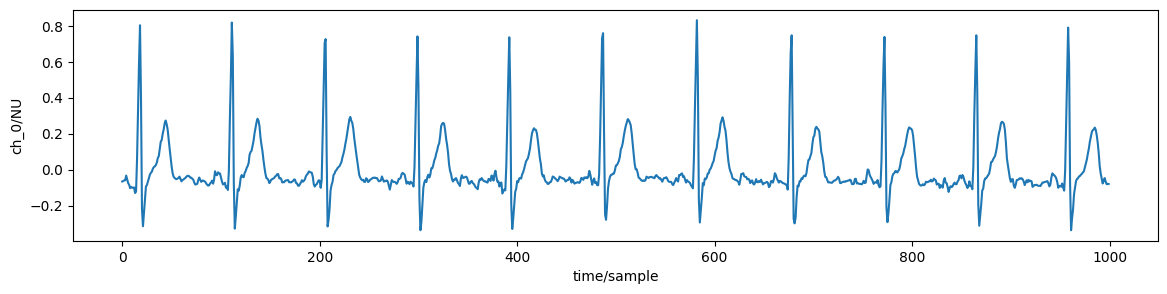

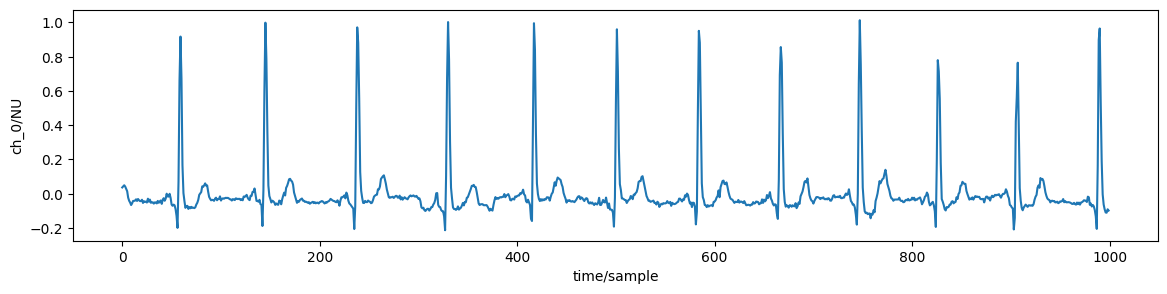

In [6]:
X_train, y_train = aug(X_train, y_train)

### Борьба с дисбалансом классов

In [7]:
X_train, y_train = elimination_imbalance(X_train, y_train)
count_of_class(X_train, y_train)
print(X_train.shape, y_train.shape)

2000
2000
2000
1500
1500
(9000, 1000, 12) (9000, 5)


### Преобразование Фурье

In [8]:
X_train_ft = fourier_transform(X_train)
X_test_ft = fourier_transform(X_test)

### Скользящее среднее

In [9]:
X_train_ra = rolling_average(X_train)
X_test_ra = rolling_average(X_test)

### Визуализация

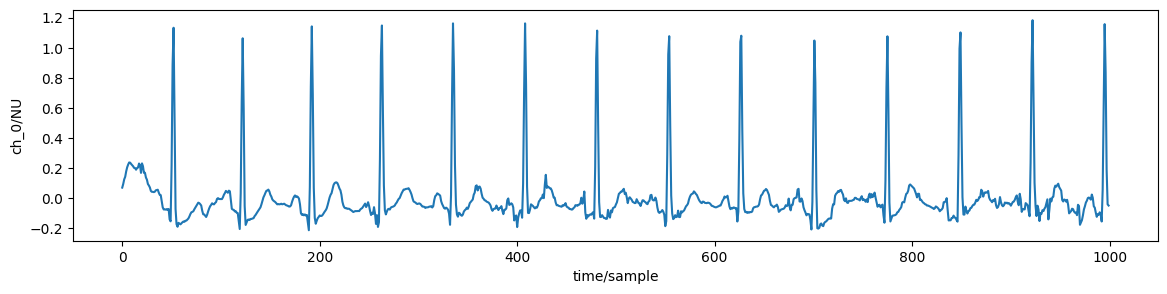

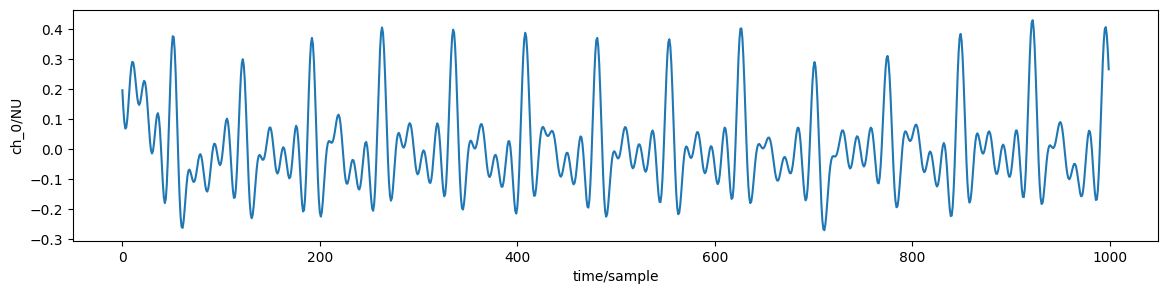

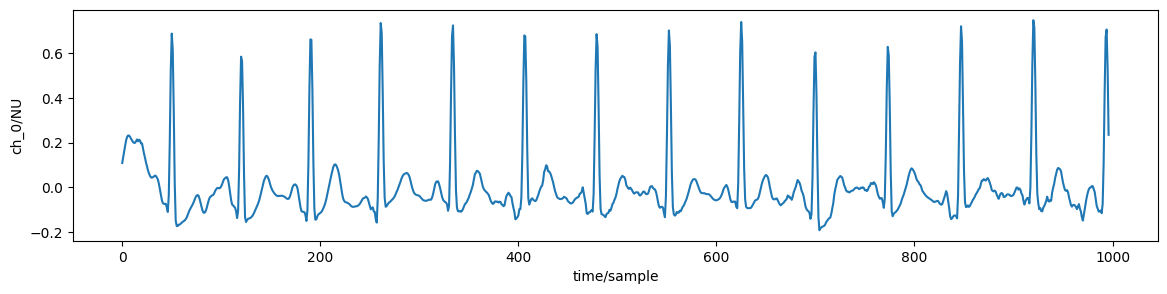

In [10]:
# plot_ts(X_train)
# plot_ts(X_train_ft)
# plot_ts(X_train_ra)
wfdb.plot_items(signal = X_train[0, :, 0], figsize = (14, 3))
wfdb.plot_items(signal = X_train_ft[0, :, 0], figsize = (14, 3))
wfdb.plot_items(signal = X_train_ra[0, :, 0], figsize = (14, 3))

### Стандартизация X_train

In [11]:
X_train_ft_st, X_test_ft_st = standard_scaler(X_train_ft, X_test_ft)
X_train_ra_st, X_test_ra_st = standard_scaler(X_train_ra, X_test_ra)
X_train_st, X_test_st = standard_scaler(X_train, X_test)

In [12]:
del X_train
del X_test

# Визуализация

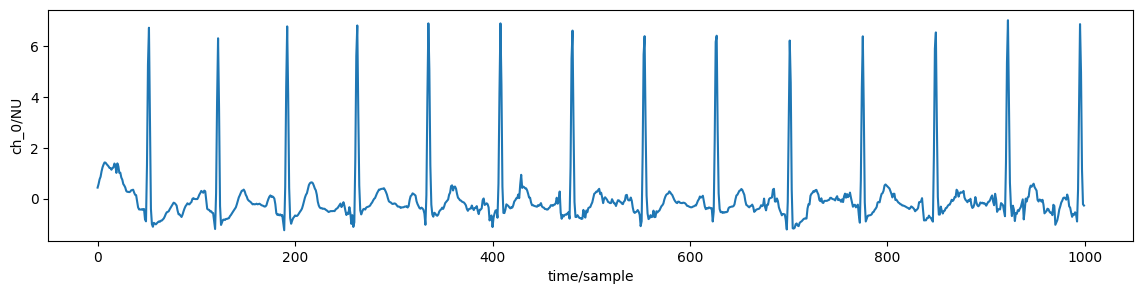

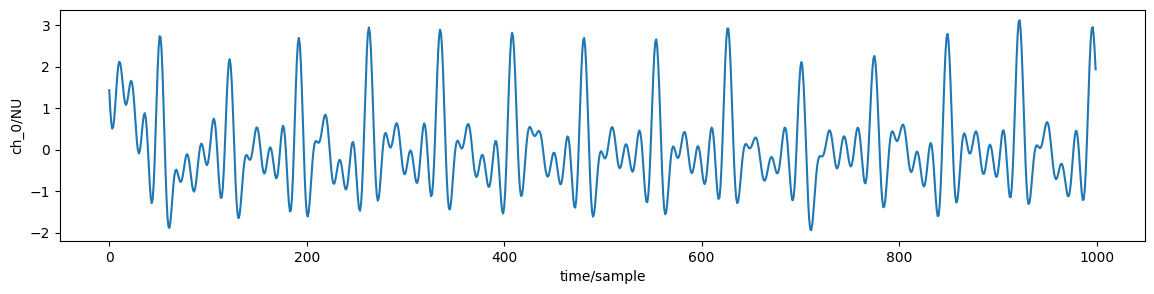

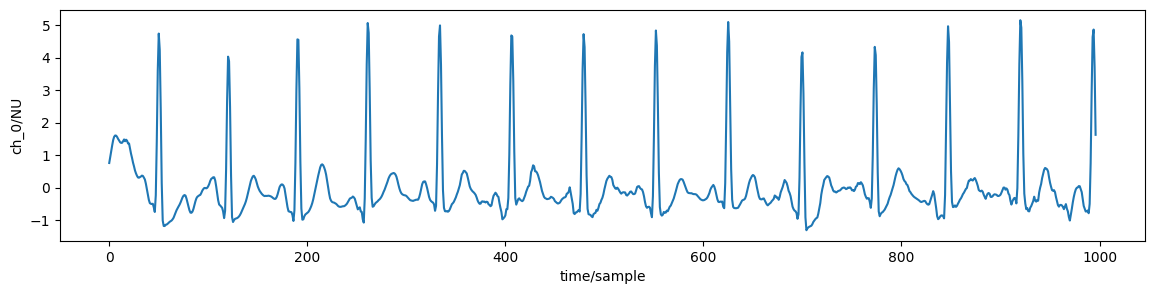

In [13]:
wfdb.plot_items(signal = X_train_st[0, :, 0], figsize = (14, 3))
wfdb.plot_items(signal = X_train_ft_st[0, :, 0], figsize = (14, 3))
wfdb.plot_items(signal = X_train_ra_st[0, :, 0], figsize = (14, 3))

# Применение алгоритмов машинного обучения
Рассматриваем следующие алгоритмы машинного обучения:
* Time Series Forest (простой алгоритм, не находит тренды, но иногда ведет себя хорошо)

* Bag-of-sfa-symbols ()

* Shaplet Classifier ()

* ROCKET (рандомная свертка)

* HIVE-COTE (ансамбль из выше перечисленных)

* NN

* кстати еще идея по трансформации: по сигналу зафигачить спектрограмму и получить картинку. С картинками много нейронок создано

In [14]:
X_train_st_sum = list_sum(X_train_st)
X_train_ft_st_sum = list_sum(X_train_ft_st)
X_train_ra_st_sum = list_sum(X_train_ra_st)
X_test_st_sum = list_sum(X_test_st)
X_test_ft_st_sum = list_sum(X_test_ft_st)
X_test_ra_st_sum = list_sum(X_test_ra_st)
del X_train_st
del X_train_ft_st
del X_train_ra_st
del X_test_st
del X_test_ft_st
del X_test_ra_st

### TimeSeriesForestClassifier

0.31584306514823557
0.3793939393939394
              precision    recall  f1-score   support

           0       0.23      0.39      0.29       184
           1       0.17      0.50      0.25        56
           2       0.19      0.22      0.20       256
           3       0.69      0.42      0.52       912
           4       0.27      0.36      0.31       242

    accuracy                           0.38      1650
   macro avg       0.31      0.38      0.32      1650
weighted avg       0.48      0.38      0.41      1650



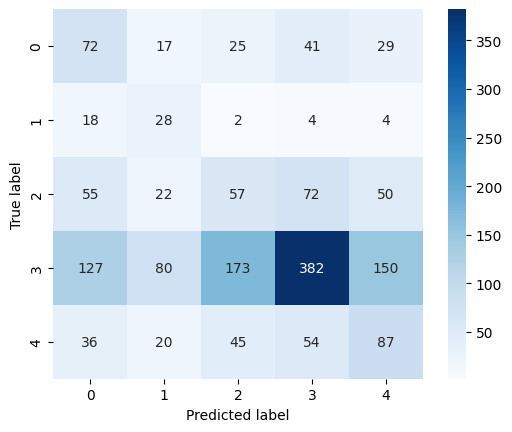

In [15]:
clf = TimeSeriesForestClassifier(n_estimators=10)
clf.fit(X_train_st_sum, np.argmax(y_train, axis=1))
y_pred = clf.predict(X_test_st_sum)
print(f1_score(np.argmax(y_test, axis=1), y_pred, average='macro'))
print(accuracy_score(np.argmax(y_test, axis=1), y_pred))
draw_confusion_matrix(np.argmax(y_test, axis=1), y_pred)

0.31378823203744843
0.3884848484848485
              precision    recall  f1-score   support

           0       0.24      0.41      0.30       184
           1       0.11      0.32      0.17        56
           2       0.22      0.30      0.26       256
           3       0.71      0.43      0.53       912
           4       0.29      0.34      0.31       242

    accuracy                           0.39      1650
   macro avg       0.31      0.36      0.31      1650
weighted avg       0.50      0.39      0.42      1650



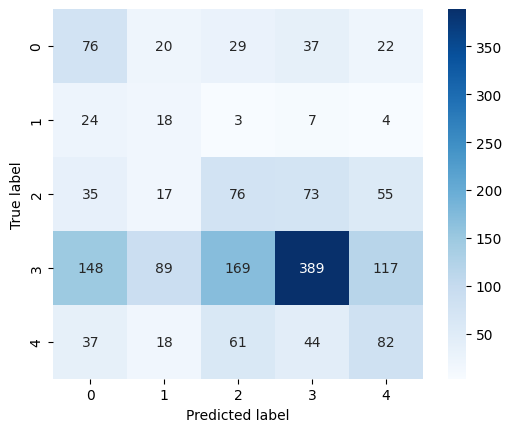

In [16]:
clf.fit(X_train_ft_st_sum, np.argmax(y_train, axis=1))
y_pred = clf.predict(X_test_ft_st_sum)
print(f1_score(np.argmax(y_test, axis=1), y_pred, average='macro'))
print(accuracy_score(np.argmax(y_test, axis=1), y_pred))
draw_confusion_matrix(np.argmax(y_test, axis=1), y_pred)

0.3037312308099988
0.3690909090909091
              precision    recall  f1-score   support

           0       0.21      0.40      0.27       184
           1       0.12      0.38      0.19        56
           2       0.19      0.23      0.21       256
           3       0.69      0.40      0.50       912
           4       0.31      0.38      0.34       242

    accuracy                           0.37      1650
   macro avg       0.31      0.36      0.30      1650
weighted avg       0.48      0.37      0.40      1650



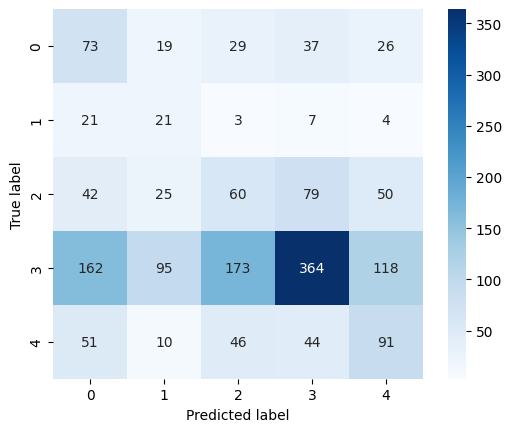

In [17]:
clf.fit(X_train_ra_st_sum, np.argmax(y_train, axis =1))
y_pred = clf.predict(X_test_ra_st_sum)
print(f1_score(np.argmax(y_test, axis=1), y_pred, average='macro'))
print(accuracy_score(np.argmax(y_test, axis=1), y_pred))
draw_confusion_matrix(np.argmax(y_test, axis=1), y_pred)

In [18]:
# # Определение пайплайна
# pipeline = Pipeline([
#     ('augment', aug()),
#     ('standardscaler', standard_scaler()),
#     ('classifier', RocketClassifier(num_kernels=1500))
# ])

# pipeline.fit(X_train, y_train)
# y_pred = pipeline.predict(X_test)
# print(f1_score(y_test, y_pred))
# print(accuracy(y_test, y_pred))

In [19]:
# rocket = RocketClassifier(num_kernels=100)
# rocket.fit(X_train_st, np.argmax(y_train, axis=1))
# y_pred = rocket.predict(X_test_st)
# print(f1_score(np.argmax(y_test, axis=1), y_pred, average='macro'))
# print(accuracy_score(np.argmax(y_test, axis=1), y_pred))
# draw_confusion_matrix(np.argmax(y_test, axis=1), y_pred)

# rocket.fit(X_train_ft_st_sum, np.argmax(y_train, axis=1))
# y_pred = rocket.predict(X_test_ft_st_sum)
# print(f1_score(np.argmax(y_test, axis=1), y_pred, average='macro'))
# print(accuracy_score(np.argmax(y_test, axis=1), y_pred))

# rocket.fit(X_train_ra_st_sum, np.argmax(y_train, axis=1))
# y_pred = rocket.predict(X_test_ra_st_sum)
# print(f1_score(np.argmax(y_test, axis=1), y_pred, average='macro'))
# print(accuracy_score(np.argmax(y_test, axis=1), y_pred))